In [119]:
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import seaborn as sns

competitions = sb.competitions()
print(competitions[['competition_id', 'competition_name', 'season_name', 'season_id']].head())


   competition_id        competition_name season_name  season_id
0               9           1. Bundesliga   2023/2024        281
1               9           1. Bundesliga   2015/2016         27
2            1267  African Cup of Nations        2023        107
3              16        Champions League   2018/2019          4
4              16        Champions League   2017/2018          1


In [120]:
matches = sb.matches(competition_id=16, season_id=1)
print(matches[['match_id', 'home_team', 'away_team']].head())

   match_id    home_team  away_team
0     18245  Real Madrid  Liverpool


In [121]:
match_id = matches.loc[0, 'match_id']
print("Match ID selezionato:", match_id)

Match ID selezionato: 18245


In [122]:
events = sb.events(match_id=match_id)
print("Numero totale di eventi:", len(events))

Numero totale di eventi: 3497


In [123]:
team_name = 'Real Madrid'
player_name = 'Luka Modrić'
shots = events[(events['type'] == 'Shot') & (events['team'] == team_name)].copy()
passes = events[(events['type'] == 'Pass') & (events['team'] == team_name)]
print("Numero di passaggi:", len(passes))
shots = events[events['type'] == 'Shot']
print(shots[['player', 'team', 'shot_outcome']].head(50))

Numero di passaggi: 673
                                   player         team shot_outcome
3400                  Georginio Wijnaldum    Liverpool      Blocked
3401                        Mohamed Salah    Liverpool      Blocked
3402  Roberto Firmino Barbosa de Oliveira    Liverpool        Off T
3403       Marcelo Vieira da Silva Júnior  Real Madrid        Off T
3404                  James Philip Milner    Liverpool      Blocked
3405                        Mohamed Salah    Liverpool      Blocked
3406                           Sadio Mané    Liverpool      Blocked
3407  Cristiano Ronaldo dos Santos Aveiro  Real Madrid        Off T
3408                      Virgil van Dijk    Liverpool        Off T
3409  Roberto Firmino Barbosa de Oliveira    Liverpool      Blocked
3410               Trent Alexander-Arnold    Liverpool        Saved
3411                          Luka Modrić  Real Madrid      Blocked
3412                        Karim Benzema  Real Madrid      Blocked
3413  Cristiano Ronaldo 

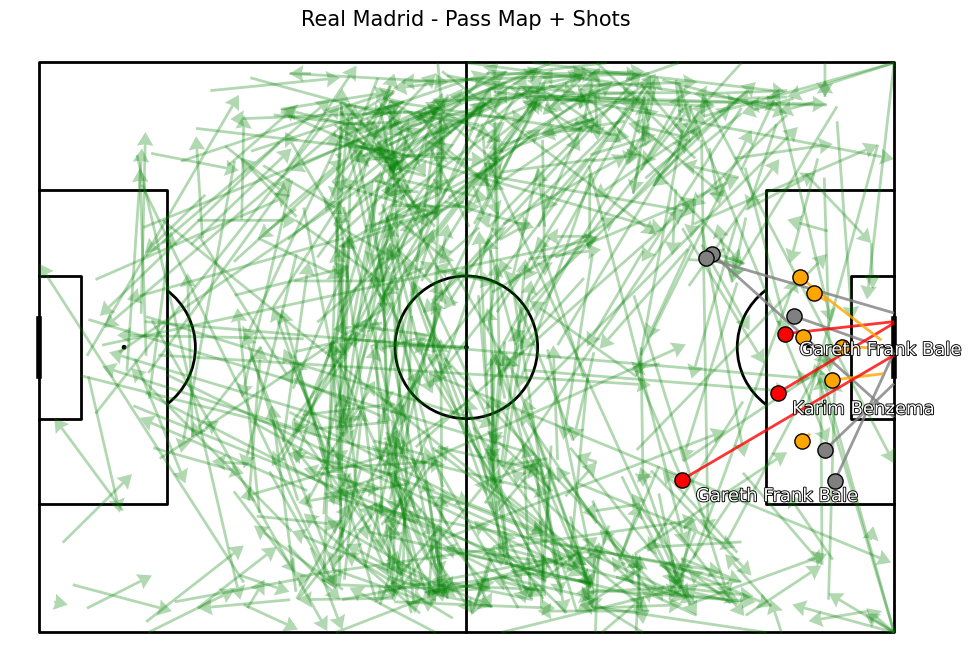

In [141]:

shots = events[(events['type'] == 'Shot') & (events['team'] == team_name)].copy()

shots['x'] = shots['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
shots['y'] = shots['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
shots['end_x'] = shots['shot_end_location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
shots['end_y'] = shots['shot_end_location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

passes.loc[:, 'x'] = passes['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
passes.loc[:, 'y'] = passes['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
passes.loc[:, 'end_x'] = passes['pass_end_location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
passes.loc[:, 'end_y'] = passes['pass_end_location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

pitch = Pitch(line_color='black', pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(10, 7))

pitch.arrows(
    passes['x'], passes['y'], passes['end_x'], passes['end_y'],
    width=2, headwidth=6, color='green', ax=ax, alpha=0.3
)

for _, shot in shots.iterrows():
    outcome = None
    if 'shot_outcome.name' in shot:
        outcome = shot['shot_outcome.name']
    elif 'shot_outcome' in shot:
        if isinstance(shot['shot_outcome'], dict):
            outcome = shot['shot_outcome'].get('name')
        else:
            outcome = shot['shot_outcome']

    if outcome == 'Goal':
        txt= ax.text(shot['x']+2, shot['y']+3, shot['player'], fontsize=13, color='white', zorder=8)
        txt.set_path_effects([
        path_effects.Stroke(linewidth=1.3, foreground='black'),
        path_effects.Normal()
    ])
        color = 'red'
    elif outcome in ['Saved', 'Saved Off Target', 'Blocked', 'Saved To Post']:
        color = 'orange'
    else:
        color = 'gray'

  
    pitch.lines(
        shot['x'], shot['y'],
        shot['end_x'], shot['end_y'],
        color=color, lw=2, ax=ax, zorder=2, alpha=0.8
    )
    
    pitch.scatter(
        shot['x'], shot['y'], s=120, color=color,
        ax=ax, edgecolors='black', zorder=3
    )


ax.set_title(f"{team_name} - Pass Map + Shots", fontsize=15)
plt.show()


In [132]:
print(passes[['player', 'x', 'y', 'end_x', 'end_y']].head(10))

                            player     x     y  end_x  end_y
8                   Raphaël Varane  27.4  60.2   36.1   71.6
9                      Luka Modrić  35.3  75.4   22.4   76.6
10           Daniel Carvajal Ramos  22.3  76.6   33.4   68.0
11        Carlos Henrique Casimiro  36.2  75.3   43.6   62.0
16             Sergio Ramos García  14.7  23.2   56.7    6.2
17  Marcelo Vieira da Silva Júnior  57.5   4.6   49.2   15.6
18        Carlos Henrique Casimiro  48.8  18.4   49.8   12.5
19                      Toni Kroos  48.8  13.9   36.1   56.3
20                  Raphaël Varane  41.3  54.8   34.4   40.2
21             Sergio Ramos García  39.1  36.5   65.4   13.1


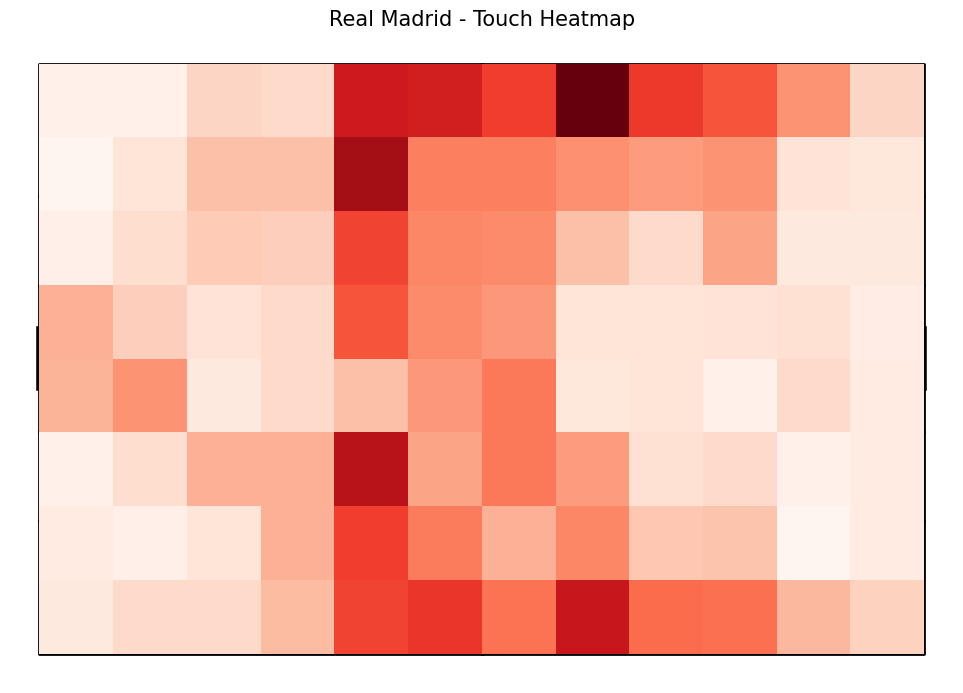

In [142]:
touches = events[events['team'] == team_name].copy()
touches['x'] = touches['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
touches['y'] = touches['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

fig, ax = pitch.draw(figsize=(10, 7))
bin_statistic = pitch.bin_statistic(
    touches['x'].dropna(), 
    touches['y'].dropna(), 
    statistic='count', 
    bins=(12, 8)
)
pitch.heatmap(bin_statistic, ax=ax, cmap='Reds')
ax.set_title(f"{team_name} - Touch Heatmap", fontsize=15)
plt.show()